In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install arff

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime

Data reading & preprocessing

In [ ]:
solvent_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'solvent')
solvent_data.set_index('solvent_name', inplace = True)
solvent_columns = list(solvent_data.columns)

In [ ]:
nucleophile_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'nucleophiles')
nucleophile_data.set_index('nucleophile_name', inplace = True)
nucleophile_columns = list(nucleophile_data.columns)

In [ ]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.set_index('catalyst_name', inplace = True)
catalyst_columns = list(catalyst_data.columns)

In [ ]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

#Taking care of catalyst R/S
r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')
    #print(r_catalyst_data.iloc[i, 1])
#r_catalyst_data.drop(17, inplace = True)

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')
    #print(s_catalyst_data.iloc[i, 1])

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)
catalyst_data.set_index('catalyst_name', inplace = True)

catalyst_columns = list(catalyst_data.columns)

# catalyst_data

In [ ]:
iminium_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'iminiums')
iminium_data.rename(columns = {'imine': 'iminium_name', 'electronic energy difference (kcal/mol) ': 'electronic energy difference (kcal/mol)'}, inplace = True)
#removed space at the end of electronic energy
iminium_data.set_index('iminium_name', inplace = True)
iminium_data.drop(labels = ['Unnamed: 1'], axis = 1, inplace = True)
for i in range(1, 181):
    z_iminium_name = '(Z)-Iminium ' + str(i)
    e_iminium_name = '(E)-Iminium ' + str(i)
    iminium_data.loc[z_iminium_name, 'electronic energy difference (kcal/mol)'] = iminium_data.loc[e_iminium_name, 'electronic energy difference (kcal/mol)']
iminium_columns = list(iminium_data.columns)

In [ ]:
class Reaction():

    def __init__(self, name, entry, catalyst, nucleophile, substrate, solvent, iminium_type, iminium, majorenantiomer, minorenantiomer, ee, G):
        self.name = name
        self.entry = entry
        self.catalyst = catalyst
        self.nucleophile = nucleophile
        self.substrate = substrate
        self.solvent = solvent
        self.iminium_type = iminium_type
        self.iminium = iminium
        self.majorenantiomer = majorenantiomer
        self.minorenantiomer = minorenantiomer
        self.ee = ee
        self.G = G

        self.solvent_properties = dict()
        for column in solvent_columns:
            self.solvent_properties[column] = solvent_data.loc[solvent, column]

        self.catalyst_properties = dict()
        for column in catalyst_columns:
            self.catalyst_properties[column] = catalyst_data.loc[catalyst, column]

        self.nucleophile_properties = dict()
        for column in nucleophile_columns:
            self.nucleophile_properties[column] = nucleophile_data.loc[nucleophile, column]

        self.e_iminium = '(E)-' + str(iminium)
        self.z_iminium = '(Z)-' + str(iminium)

        self.e_iminium_properties = dict()
        self.z_iminium_properties = dict()
        for column in iminium_columns:
            self.e_iminium_properties[column] = iminium_data.loc[self.e_iminium, column]
            self.z_iminium_properties[column] = iminium_data.loc[self.z_iminium, column]



    def __repr__(self):
        return "Reaction - {}".format(self.name)
        #iminium stuff

In [ ]:
reactions = dict()

def process_data(reaction_number, reaction, iminium_type, sheetname = None):
    reaction_file = '/content/drive/My Drive/Colab Notebooks/material_project/data/reaction information/' + str(reaction_number) + ' ' + reaction + '.xlsx'
    if sheetname == None:
        data = pd.read_excel(reaction_file)
    else:
        data = pd.read_excel(reaction_file, sheet_name = sheetname)

    data.set_index('entry', inplace = True)

    entries = len(data)
    for entry in range(1, entries + 1):
        if sheetname == None:
            reaction_name = reaction + ' ' + str(entry)
        else:
            reaction_name = reaction + ' ' + sheetname + ' ' + str(entry)


        reactions[reaction_name] = Reaction(reaction_name,
                                            entry,
                                            data.loc[entry, 'Catalyst'],
                                            data.loc[entry, 'Nucleophile'],
                                            data.loc[entry, 'Substrate'],
                                            data.loc[entry, 'Solvent'],
                                            iminium_type,
                                            data.loc[entry, 'Iminium'],
                                            data.loc[entry, 'Major Enantiomer'],
                                            data.loc[entry, 'Minor Enantiomer'],
                                            data.loc[entry, 'ee'],
                                            data.loc[entry, 'ΔΔG‡'])



In [ ]:
process_data(1, 'Addition of Alcohols', 'E', 'Scope')
process_data(2, 'Addition of thiols', 'E', 'Catalyst & solvent screening da')
process_data(2, 'Addition of thiols', 'E', 'Effect of catalyst loading')
process_data(2, 'Addition of thiols', 'E', 'Imine scope')
process_data(2, 'Addition of thiols', 'E', 'Thiol scope')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Catalyst screening data')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Scope')
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Optimization of catalyst and re")
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Imine scope")
process_data(5, 'Addition of diazoacetamides', 'E', 'Catalyst screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Solvent screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Substrate(s) scope')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Catalyst screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Solvent screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Imine scope')
process_data(7, 'Peroxidation of imines', 'E', 'Catalyst screening data')
process_data(7, 'Peroxidation of imines', 'E', 'Solvent screening data')
#process_data(7, 'Peroxidation of imines', 'E', 'Substrate(s) scope')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Catalyst screening and reaction')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Scope')
process_data(9, 'Transfer Hydrogenation of Enamides', 'E', 'Scope')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Catalyst screening data')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Imine scope')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Catalyst screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Solvent screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Imine scope')
#process_data(12, 'Reductive amination of N-aryl imines (Macmillan)', 'Z', 'Reaction optimization')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Imine scope')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Catalyst screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Benzothiazoline screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Imine scope')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Catalyst screening data')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Imine scope')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 1 benzothiazoline')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 2 dihydropyridine')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Catalyst screening data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Solvent data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Imine scope')
#process_data(18, 'Addition of enecarbamates to benzoyl imines')
#process_data(19, 'Hydrogenation of fluorinated alkynyl ketimines')
#process_data(20, 'Addition of thiols to imines (Denmark)')

In [ ]:
print(len(reactions))

342


In [ ]:
catalyst = pd.DataFrame(columns = ['Reaction'] + catalyst_columns)
catalyst.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in catalyst_columns:
        catalyst.loc[reaction, column] = reactions[reaction].catalyst_properties[column]

#first column is numerical

In [ ]:
nucleophile = pd.DataFrame(columns = ['Reaction'] + nucleophile_columns)
nucleophile.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in nucleophile_columns:
        nucleophile.loc[reaction, column] = reactions[reaction].nucleophile_properties[column]

#first column is numerical

In [ ]:
solvent = pd.DataFrame(columns = ['Reaction'] + solvent_columns)
solvent.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in solvent_columns:
        solvent.loc[reaction, column] = reactions[reaction].solvent_properties[column]

#first column is numerical

In [ ]:
iminium = pd.DataFrame(columns = ['Reaction', "iminium_type"] + iminium_columns)
iminium.set_index('Reaction', inplace = True)

for reaction in reactions:
    if reactions[reaction].iminium_type == 'E':
        iminium.loc[reaction, "iminium_type"] = 'E'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].e_iminium_properties[column]
    elif reactions[reaction].iminium_type == 'Z':
        iminium.loc[reaction, "iminium_type"] = 'Z'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].z_iminium_properties[column]



In [ ]:
ee = pd.DataFrame(columns = ['Reaction', 'ee'])
ee.set_index('Reaction', inplace = True)

for reaction in reactions:
    ee.loc[reaction, 'ee'] = reactions[reaction].ee

In [ ]:
Y = pd.DataFrame(columns = ['Reaction', 'ΔΔG‡'])
Y.set_index('Reaction', inplace = True)

for reaction in reactions:
    Y.loc[reaction, 'ΔΔG‡'] = reactions[reaction].G


In [ ]:
print(catalyst.shape, nucleophile.shape, solvent.shape, iminium.shape, ee.shape)

(342, 85) (342, 15) (342, 160) (342, 22) (342, 1)


In [ ]:
X_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1),
               nucleophile.drop(['nucleophile'], axis = 1),
               solvent.drop(['solvent'], axis = 1),
               iminium.drop(['iminium_type'], axis = 1)], axis = 1)
X_iminium.shape

(342, 278)

In [ ]:
#no iminium features
X_no_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1),
               nucleophile.drop(['nucleophile'], axis = 1),
               solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_iminium.shape

(342, 257)

In [ ]:
X_no_nucleophile = pd.concat([catalyst.drop(['Ar group'], axis = 1),
                   solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_nucleophile.shape

(342, 243)

In [ ]:
for reaction in reactions:
    if iminium.loc[reaction, 'iminium_type'] == 'Z':
        Y.loc[reaction, 'ΔΔG‡'] = Y.loc[reaction, 'ΔΔG‡'] * (-1)

In [ ]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.8.1.
The scikit-learn version is 1.2.2.


In [ ]:
!pip install eli5
!conda install -c conda-forge eli5

/bin/bash: line 1: conda: command not found


In [ ]:
# -*- coding: utf-8 -*-

from functools import partial
from typing import List

import numpy as np
from sklearn.model_selection import check_cv
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import check_array, check_random_state
from sklearn.base import (
    BaseEstimator,
    MetaEstimatorMixin,
    clone,
    is_classifier
)
from sklearn.metrics import check_scoring

from eli5.permutation_importance import get_score_importances
from eli5.sklearn.utils import pandas_available

if pandas_available:
    import pandas as pd

CAVEATS_CV_NONE = """
Feature importances are computed on the same data as used for training,
i.e. feature importances don't reflect importance of features for
generalization.
"""

CAVEATS_CV = """
Feature importances are not computed for the final estimator;
they are computed for a sequence of estimators trained and evaluated
on train/test splits. So they tell you about importances of features
for generalization, but not feature importances of a particular trained model.
"""

CAVEATS_PREFIT = """
If feature importances are computed on the same data as used for training,
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.
"""


class PermutationImportance(BaseEstimator, MetaEstimatorMixin):
    print("AAAAAAAAAAA1111")
    """Meta-estimator which computes ``feature_importances_`` attribute
    based on permutation importance (also known as mean score decrease).

    :class:`~PermutationImportance` instance can be used instead of
    its wrapped estimator, as it exposes all estimator's common methods like
    ``predict``.

    There are 3 main modes of operation:

    1. cv="prefit" (pre-fit estimator is passed). You can call
       PermutationImportance.fit either with training data, or
       with a held-out dataset (in the latter case ``feature_importances_``
       would be importances of features for generalization). After the fitting
       ``feature_importances_`` attribute becomes available, but the estimator
       itself is not fit again. When cv="prefit",
       :meth:`~PermutationImportance.fit` must be called
       directly, and :class:`~PermutationImportance` cannot be used with
       ``cross_val_score``, ``GridSearchCV`` and similar utilities that clone
       the estimator.
    2. cv=None. In this case :meth:`~PermutationImportance.fit` method fits
       the estimator and computes feature importances on the same data, i.e.
       feature importances don't reflect importance of features for
       generalization.
    3. all other ``cv`` values. :meth:`~PermutationImportance.fit` method
       fits the estimator, but instead of computing feature importances for
       the concrete estimator which is fit, importances are computed for
       a sequence of estimators trained and evaluated on train/test splits
       according to ``cv``, and then averaged. This is more resource-intensive
       (estimators are fit multiple times), and importances are not computed
       for the final estimator, but ``feature_importances_`` show importances
       of features for generalization.

    Mode (1) is most useful for inspecting an existing estimator; modes
    (2) and (3) can be also used for feature selection, e.g. together with
    sklearn's SelectFromModel or RFE.

    Currently :class:`~PermutationImportance` works with dense data.

    Parameters
    ----------
    estimator : object
        The base estimator. This can be both a fitted
        (if ``prefit`` is set to True) or a non-fitted estimator.

    scoring : string, callable or None, default=None
        Scoring function to use for computing feature importances.
        A string with scoring name (see scikit-learn `docs`_) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
        If ``None``, the ``score`` method of the estimator is used.

        .. _docs: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

    n_iter : int, default 5
        Number of random shuffle iterations. Decrease to improve speed,
        increase to get more precise estimates.

    random_state : integer or numpy.random.RandomState, optional
        random state

    cv : int, cross-validation generator, iterable or "prefit"
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

            - None, to disable cross-validation and compute feature importances
              on the same data as used for training.
            - integer, to specify the number of folds.
            - An object to be used as a cross-validation generator.
            - An iterable yielding train/test splits.
            - "prefit" string constant (default).

        If "prefit" is passed, it is assumed that ``estimator`` has been
        fitted already and all data is used for computing feature importances.

    refit : bool
        Whether to fit the estimator on the whole data if cross-validation
        is used (default is True).

    Attributes
    ----------
    feature_importances_ : array
        Feature importances, computed as mean decrease of the score when
        a feature is permuted (i.e. becomes noise).

    feature_importances_std_ : array
        Standard deviations of feature importances.

    results_ : list of arrays
        A list of score decreases for all experiments.

    scores_ : array of float
        A list of base scores for all experiments (with no features permuted).

    estimator_ : an estimator
        The base estimator from which the :class:`~PermutationImportance`
        instance  is built. This is stored only when a non-fitted estimator
        is passed to the :class:`~PermutationImportance`, i.e when ``cv`` is
        not "prefit".

    rng_ : numpy.random.RandomState
        random state
    """
    def __init__(self, estimator, scoring='neg_mean_squared_error', n_iter=1, random_state=None,
                 cv='prefit', refit=True):
        # type: (...) -> None
        if isinstance(cv, str) and cv != "prefit":
            raise ValueError("Invalid cv value: {!r}".format(cv))
        self.refit = refit
        self.estimator = estimator
        self.scoring = scoring
        self.n_iter = n_iter
        self.random_state = random_state
        self.cv = cv
        self.rng_ = check_random_state(random_state)

    def _wrap_scorer(self, base_scorer, pd_columns):
        def pd_scorer(model, X, y):
            X = pd.DataFrame(X, columns=pd_columns)
            return base_scorer(model, X, y)
        return pd_scorer

    def fit(self, X, y, groups=None, **fit_params):
        # type: (...) -> PermutationImportance
        """Compute ``feature_importances_`` attribute and optionally
        fit the base estimator.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.

        y : array-like, shape (n_samples,)
            The target values (integers that correspond to classes in
            classification, real numbers in regression).

        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.

        **fit_params : Other estimator specific parameters

        Returns
        -------
        self : object
            Returns self.
        """
        self.scorer_ = check_scoring(self.estimator, scoring=self.scoring)

        if pandas_available and isinstance(X, pd.DataFrame):
            self.scorer_ = self._wrap_scorer(self.scorer_, X.columns)

        if self.cv != "prefit" and self.refit:
            self.estimator_ = clone(self.estimator)
            self.estimator_.fit(X, y, **fit_params)

        X = check_array(X, force_all_finite='allow-nan')

        if self.cv not in (None, "prefit"):
            si = self._cv_scores_importances(X, y, groups=groups, **fit_params)
        else:
            si = self._non_cv_scores_importances(X, y)
        scores, results = si
        self.scores_ = np.array(scores)
        self.results_ = results
        self.feature_importances_ = np.mean(results, axis=0)
        # print("AAAAAAAAAAA")
        # print(len(results))
        self.feature_importances_std_ = np.std(results, axis=0)
        return self


    def _cv_scores_importances(self, X, y, groups=None, **fit_params):
        # print("1")
        assert self.cv is not None
        cv = check_cv(self.cv, y, is_classifier(self.estimator))
        feature_importances = []  # type: List
        base_scores = []  # type: List[float]
        weights = fit_params.pop('sample_weight', None)
        fold_fit_params = fit_params.copy()
        for train, test in cv.split(X, y, groups):
            if weights is not None:
                fold_fit_params['sample_weight'] = weights[train]
            est = clone(self.estimator).fit(X[train], y[train], **fold_fit_params)
            score_func = partial(self.scorer_, est)
            _base_score, _importances = self._get_score_importances(
                score_func, X[test], y[test])
            base_scores.extend([_base_score] * len(_importances))
            feature_importances.extend(_importances)
        return base_scores, feature_importances

    def _non_cv_scores_importances(self, X, y):
        # print("2")
        score_func = partial(self.scorer_, self.wrapped_estimator_)
        base_score, importances = self._get_score_importances(score_func, X, y)
        return [base_score] * len(importances), importances

    def _get_score_importances(self, score_func, X, y):
        # print("3")
        # print(self.scoring)
        # print(self.n_iter)
        return get_score_importances(score_func, X, y, n_iter=self.n_iter,
                                     random_state=self.rng_)

    @property
    def caveats_(self):
        # type: () -> str
        if self.cv == 'prefit':
            return CAVEATS_PREFIT
        elif self.cv is None:
            return CAVEATS_CV_NONE
        return CAVEATS_CV

    # ============= Exposed methods of a wrapped estimator:

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def score(self, X, y=None, *args, **kwargs):
        return self.wrapped_estimator_.score(X, y, *args, **kwargs)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def predict(self, X):
        return self.wrapped_estimator_.predict(X)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def predict_proba(self, X):
        return self.wrapped_estimator_.predict_proba(X)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def predict_log_proba(self, X):
        return self.wrapped_estimator_.predict_log_proba(X)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def decision_function(self, X):
        return self.wrapped_estimator_.decision_function(X)

    @property
    def wrapped_estimator_(self):
        if self.cv == "prefit" or not self.refit:
            return self.estimator
        return self.estimator_

    @property
    def _estimator_type(self):
        return self.estimator._estimator_type

    @property
    def classes_(self):
        return self.wrapped_estimator_.classes_


AAAAAAAAAAA1111


Run 100 replications with Monte-carlo cross validation

In [ ]:
X = X_iminium

In [ ]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import heapq
import matplotlib.pyplot as plt


from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot


from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr
from numpy.random import random


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
X.shape

(342, 278)

In [ ]:

X_train_train, X_valid, Y_train_train, Y_valid = train_test_split( X_train1,Y_train1, test_size = 0.2, random_state = 100)



X_valid=X_valid.to_numpy()
Y_valid=Y_valid.to_numpy()
X_train_train=X_train_train.to_numpy()
Y_train_train=Y_train_train.to_numpy()

Bayesian optimization for hyperparameter tuning

In [ ]:

validation_replication=1
result_valid=np.zeros(validation_replication)
result_valid=np.reshape(result_valid,(1,validation_replication))








def objective(x1):

    # Constraints for each hyperparameter
    # All hyperparameters are positive integers.
    # Minimum of "n_estimators" : 1.

    a1 = int(x1)


    if a1<1:
        a1=1


# Performance evaluation for  validation set
    for j in range(0,1):
        # Fit the model with training data and check the Mean Absolute Percentage Error (MAPE) of validation data
        reg_m = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=a1,random_state=5))
        reg_m.fit(X_train_train, Y_train_train.ravel());

        predicted_y_m = reg_m.predict(X_valid);
        prediction=np.reshape(predicted_y_m,(predicted_y_m.shape[0],1))
        result_valid[0,j] =(mean_squared_error(Y_valid, prediction))
    # Since Bayesian Optimization is maximization problem, we used reciprocal as output.
    return (1/np.mean(result_valid))

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    #with catch_warnings():
        # ignore generated warnings if the distribution is thin at a given point
        #simplefilter("ignore")
        return model.predict(X, return_std=True)

# We used Expected Improvement as our acquisition function.
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    #mu = mu[:, 0]
    # calculate the Expected improvement
    probs = (mu - best) * norm.cdf((mu - best) / (std + 1E-9)) + (std + 1E-9) * norm.pdf((mu - best) / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    np.random.seed(i*100+h*100+100*i1)
    # random search, generate random samples
    X1samples = 100 * random((100,1))

    # calculate the acquisition function for each sample
    Xsamples = X1samples
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix,]



X1 = [100]
X1 = asarray(X1)


y = asarray([objective(X1)])
X = X1
X = X.reshape(len(X1),1)
y = y.reshape(len(y),1)
h=0




# Starting from given 25 points
for i1 in range(0,20):
    np.random.seed(i1*100+i*100)
    X1 = 100* random(1)

    ysample = asarray([objective(X1)])
    Xsample = X1
    Xsample = Xsample.reshape(len(X1),1)
    ysample = ysample.reshape(len(ysample),1)

    X = vstack((X,Xsample))
    y = vstack((y,ysample))
# define the surrogate model
model = GaussianProcessRegressor()
model.fit(X, y)



# Sample new points (hyperparameters) with Bayesian Optimization.
# It sequentialy samples 100 points based on the optimization.
for h in range(100):
    print(h)
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    x = asarray(x)
    # sample the point
    actual = objective(x[0])
    est, _ = surrogate(model,[x])
    actual = asarray(actual)
    #print(' f()=%3f, actual=%.3f' % (est, actual))
    # add the data to the dataset
    X = vstack((X,[x]))
    y = vstack((y,[[actual]]))
    # update the model
    model.fit(X, y)
    # best result
    ix = argmax(y)
    print("Current")
    print(x[0],1/est,1/actual)

#Provide Best hyperparameters settings based on Bayesian Optimization.
print("Best")
print((X[ix, 0],y[ix],1/y[ix]),ix)



a1=int(X[ix,0])

if a1<1:
    a1=1
print(a1)




<ipython-input-32-d7f73c659fcd>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1 = int(x1)
<ipython-input-32-d7f73c659fcd>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1 = int(x1)
<ipython-input-32-d7f73c659fcd>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1 = int(x1)
<ipython-input-32-d7f73c659fcd>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element fr

0
Current
52.20107825290352 [0.32766569] 0.3460046145306596
1
Current
74.46998848616458 [0.40748625] 0.3499650218010008
2
Current
95.9012735325267 [0.32116727] 0.3506622551594023
3
Current
15.606477160946763 [0.37585941] 0.37534861291526367
4
Current
75.20352721392534 [0.33544161] 0.35009756936781444
5
Current
73.75385543294196 [0.32460684] 0.34695524925579097
6
Current
56.665519995714895 [0.35985152] 0.3434966449819612
7
Current
63.1857841270135 [0.37524418] 0.3455227479643769
8
Current
68.83048678609227 [0.38438464] 0.3418561293444861
9
Current
49.23511771945308 [0.49626433] 0.3495142603460377
10
Current
99.72751643376303 [0.33784334] 0.35390636020323624
11
Current
97.50246580263361 [0.35435504] 0.3518830482960741
12
Current
50.499707885794585 [0.37369762] 0.3426764277062998
13
Current
98.68425536755575 [0.34467712] 0.3524614247479134
14
Current
48.37982969952556 [0.34074045] 0.35219500803224835
15
Current
14.644985432874725 [0.366925] 0.37499290021867165
16
Current
50.0558244811506 

Run 100 replications with Monte-carlo cross validation Calculate mean & standard deviation of MSE and R^2 Permutation importance analysis

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
result_important=np.zeros((278,100))
def run_random_forest(iterations,value):
    scores = pd.DataFrame(columns = ['iteration', 'MSE', 'test r^2', 'train r^2', 'total r^2'])
    #scores.set_index('iteration', inplace = True)
    for i in range(iterations):
        print(i)
        a=10*i
        parameter=a1
        #develop model & scores
        forest = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=parameter,random_state=100))
        X_train, X_test, Y_train, Y_test = train_test_split(X_train1,  Y_train1, test_size = 0.2, random_state = a)

        svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())

        #evaluating performance
        Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

        results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
        results.set_index('Reaction', inplace = True)
        results.columns = ['Actual', 'Predicted']

        Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
        train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
        train_results.set_index('Reaction', inplace = True)
        train_results.columns = ['Actual', 'Predicted']

        all_results = pd.concat([train_results, results])

        scores = scores.append({'iteration': str(i+1),
                    'MSE': mean_squared_error(Y_test, Y_pred),
                    'test r^2': r2_score(Y_test, Y_pred),
                    'train r^2': r2_score(train_results['Actual'], train_results['Predicted']),
                    'total r^2': r2_score(all_results['Actual'], all_results['Predicted'])}, ignore_index = True)

        perm = PermutationImportance(svc).fit(X_train, Y_train, scoring='neg_mean_squared_error')

        if i == 0:
            total_features_mean = (perm.feature_importances_)
        else:
            total_features_mean = total_features_mean+(perm.feature_importances_)
        result_important[:,i]=perm.feature_importances_
        if i == 0:
            total_features_std = perm.feature_importances_std_
        else:
            total_features_std = total_features_std+perm.feature_importances_std_

    return scores, total_features_mean ,  total_features_std

In [ ]:
import warnings
warnings.filterwarnings("ignore")
for i in range(1,2):
  print("Parameter")
  print(0.1*i)
  results_svr, mean, std = run_random_forest(100,i)
  print(results_svr)
  print(results_svr.mean())
  print(results_svr.std())
  # print(mean)
  # print(std)

Parameter
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   iteration       MSE  test r^2  train r^2  total r^2
0          1  0.186958  0.929176   0.988444   0.977541
1          2  0.169586  0.945842   0.987161   0.978158
2          3  0.285782  0.897422   0.989031   0.971266
3          4  0.397177  0.845102   0.987509   0.961994
4          5  0.127071  0.956904   0.984359   0.978703
..       ...       ...       ...        ...        ...
95        96  0.082551  0.974691   0.984289   0.982143
96        97  0.197688  0.941968   0.984112   0.974270
97        98  0.277388  0.902146   0.988050   0.971026
98        99  0.125365  0.956090   0.987139   0.981001
99       100  0.106678  0.953353   0.986007   0.980836

[100 rows x 5 columns]
iteration   

Analysis without Imine's features

In [ ]:
X = X_iminium

In [ ]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [ ]:
X=X_no_iminium

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM')
X_train2 = pd.read_excel('X_train2.xlsx', index_col=0)

In [ ]:
print(X_train2.shape)
print(X_no_iminium.shape)

(307, 257)
(342, 257)


In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import heapq
import matplotlib.pyplot as plt


from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot


from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr
from numpy.random import random


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Bayesian optimization for hyperparameter tuning

In [ ]:

X_train_train, X_valid, Y_train_train, Y_valid = train_test_split( X_train2,Y_train1, test_size = 0.2, random_state = 100)



X_valid=X_valid.to_numpy()
Y_valid=Y_valid.to_numpy()
X_train_train=X_train_train.to_numpy()
Y_train_train=Y_train_train.to_numpy()

In [ ]:

validation_replication=1
result_valid=np.zeros(validation_replication)
result_valid=np.reshape(result_valid,(1,validation_replication))








def objective(x1):

    # Constraints for each hyperparameter
    # All hyperparameters are positive integers.
    # Minimum of "n_estimators" : 1.

    a1 = int(x1)


    if a1<1:
        a1=1


# Performance evaluation for  validation set
    for j in range(0,1):
        # Fit the model with training data and check the Mean Absolute Percentage Error (MAPE) of validation data
        reg_m = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=a1,random_state=5))
        reg_m.fit(X_train_train, Y_train_train.ravel());

        predicted_y_m = reg_m.predict(X_valid);
        prediction=np.reshape(predicted_y_m,(predicted_y_m.shape[0],1))
        result_valid[0,j] =(mean_squared_error(Y_valid, prediction))
    # Since Bayesian Optimization is maximization problem, we used reciprocal as output.
    return (1/np.mean(result_valid))

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    #with catch_warnings():
        # ignore generated warnings if the distribution is thin at a given point
        #simplefilter("ignore")
        return model.predict(X, return_std=True)

# We used Expected Improvement as our acquisition function.
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    #mu = mu[:, 0]
    # calculate the Expected improvement
    probs = (mu - best) * norm.cdf((mu - best) / (std + 1E-9)) + (std + 1E-9) * norm.pdf((mu - best) / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    np.random.seed(i*100+h*100+100*i1)
    # random search, generate random samples
    X1samples = 100 * random((100,1))

    # calculate the acquisition function for each sample
    Xsamples = X1samples
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix,]



X1 = [100]
X1 = asarray(X1)


y = asarray([objective(X1)])
X = X1
X = X.reshape(len(X1),1)
y = y.reshape(len(y),1)
h=0




# Starting from given 25 points
for i1 in range(0,20):
    np.random.seed(i1*100+i*100)
    X1 = 100* random(1)

    ysample = asarray([objective(X1)])
    Xsample = X1
    Xsample = Xsample.reshape(len(X1),1)
    ysample = ysample.reshape(len(ysample),1)

    X = vstack((X,Xsample))
    y = vstack((y,ysample))
# define the surrogate model
model = GaussianProcessRegressor()
model.fit(X, y)



# Sample new points (hyperparameters) with Bayesian Optimization.
# It sequentialy samples 100 points based on the optimization.
for h in range(100):
    print(h)
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    x = asarray(x)
    # sample the point
    actual = objective(x[0])
    est, _ = surrogate(model,[x])
    actual = asarray(actual)
    #print(' f()=%3f, actual=%.3f' % (est, actual))
    # add the data to the dataset
    X = vstack((X,[x]))
    y = vstack((y,[[actual]]))
    # update the model
    model.fit(X, y)
    # best result
    ix = argmax(y)
    print("Current")
    print(x[0],1/est,1/actual)

#Provide Best hyperparameters settings based on Bayesian Optimization.
print("Best")
print((X[ix, 0],y[ix],1/y[ix]),ix)



a1=int(X[ix,0])

if a1<1:
    a1=1
print(a1)




0
Current
32.744116637201174 [0.15805746] 0.1746216557019809
1
Current
64.34987075099797 [0.17228898] 0.18059427030003405
2
Current
16.617307729478938 [0.17905016] 0.19914511331416124
3
Current
44.20324126661561 [0.17435405] 0.19654678670908887
4
Current
65.89371881453168 [0.17144039] 0.18058146506624279
5
Current
99.78697940607826 [0.1700389] 0.18141925360152872
6
Current
68.29879826828974 [0.20070298] 0.1777600535599036
7
Current
32.09247747884082 [0.17405354] 0.1746216557019809
8
Current
68.42810167750652 [0.17538068] 0.1777600535599036
9
Current
59.52951370332124 [0.19412565] 0.18396767360358277
10
Current
98.81400181698376 [0.1787655] 0.18056719363147636
11
Current
67.48244031375032 [0.17565549] 0.17856250694496345
12
Current
55.440862228690094 [0.20042021] 0.1910880786635097
13
Current
95.30559198738764 [0.21246055] 0.18381895966504608
14
Current
79.7818207542076 [0.20636016] 0.1824891452616693
15
Current
13.227417126405117 [0.27227529] 0.19748050133985406
16
Current
14.270973577

Run 100 replications with Monte-carlo cross validation Calculate mean & standard deviation of MSE and R^2, Permutation importance

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
result_important=np.zeros((257,100))
def run_random_forest(iterations,value):
    scores = pd.DataFrame(columns = ['iteration', 'MSE', 'test r^2', 'train r^2', 'total r^2'])
    #scores.set_index('iteration', inplace = True)
    for i in range(iterations):
        print(i)
        a=10*i
        parameter=a1
        #develop model & scores
        forest = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=parameter,random_state=100))
        X_train, X_test, Y_train, Y_test = train_test_split(X_train2,  Y_train1, test_size = 0.2, random_state = a)

        svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())

        #evaluating performance
        Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

        results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
        results.set_index('Reaction', inplace = True)
        results.columns = ['Actual', 'Predicted']

        Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
        train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
        train_results.set_index('Reaction', inplace = True)
        train_results.columns = ['Actual', 'Predicted']

        all_results = pd.concat([train_results, results])

        scores = scores.append({'iteration': str(i+1),
                    'MSE': mean_squared_error(Y_test, Y_pred),
                    'test r^2': r2_score(Y_test, Y_pred),
                    'train r^2': r2_score(train_results['Actual'], train_results['Predicted']),
                    'total r^2': r2_score(all_results['Actual'], all_results['Predicted'])}, ignore_index = True)

        perm = PermutationImportance(svc).fit(X_train, Y_train, scoring='neg_mean_squared_error')

        if i == 0:
            total_features_mean = (perm.feature_importances_)
        else:
            total_features_mean = total_features_mean+(perm.feature_importances_)
        result_important[:,i]=perm.feature_importances_
        if i == 0:
            total_features_std = perm.feature_importances_std_
        else:
            total_features_std = total_features_std+perm.feature_importances_std_



        if i==0:
          print(Y_test.shape)
          plt.figure(figsize=(8,8))
          plt.scatter(pd.concat([Y_test]), Y_pred, c='crimson')
          # plt.yscale('log')
          # plt.xscale('log')
          a111=np.asarray(pd.concat([Y_test]))
          p1 = max(max(Y_pred), max(a111))
          p2 = min(min(Y_pred), min(a111))
          plt.plot([p1, p2], [p1, p2], 'b-')
          plt.title("Scatter Plot of Activation Energy", fontsize=18)
          plt.xlabel('True Values', fontsize=15)
          plt.ylabel('Predictions', fontsize=15)
          plt.axis('equal')
          plt.show()





    return scores, total_features_mean ,  total_features_std

Parameter
0.1
0
(62, 1)


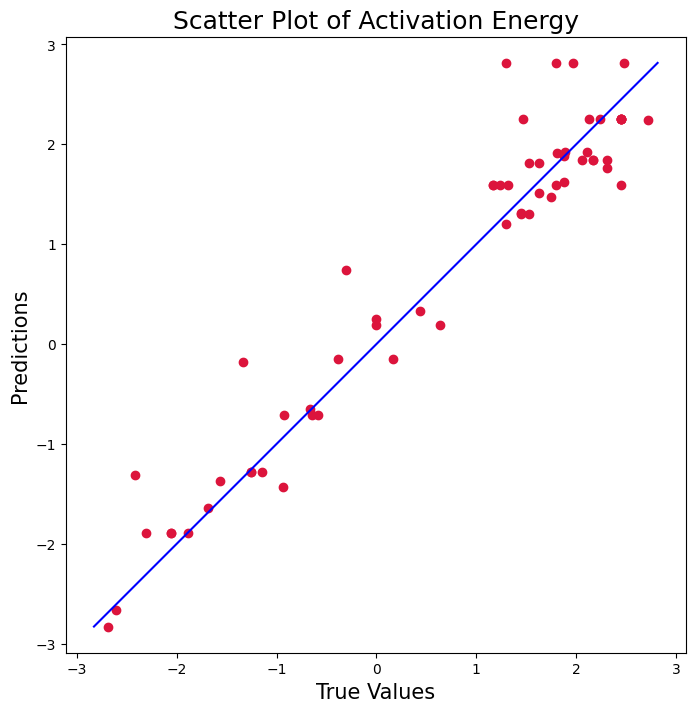

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   iteration       MSE  test r^2  train r^2  total r^2
0          1  0.201914  0.923510   0.974607   0.965256
1          2  0.155377  0.950379   0.967467   0.963836
2          3  0.334365  0.879983   0.972045   0.954319
3          4  0.152787  0.940414   0.968662   0.963643
4          5  0.136096  0.953843   0.969136   0.965992
..       ...       ...       ...        ...        ...
95        96  0.146824  0.954985   0.967277   0.964563
96        97  0.329520  0.903268   0.968256   0.953170
97        98  0.231534  0.918322   0.976161   0.964704
98        99  0.168440  0.941003   0.971065   0.965199
99       100  0.164980  0.927860   0.972596   0.965541

[100 rows x 5 columns]
iteration    1.234568e+189
M

In [ ]:
import warnings
warnings.filterwarnings("ignore")
for i in range(1,2):
  print("Parameter")
  print(0.1*i)
  results_svr, mean, std = run_random_forest(100,i)
  print(results_svr)
  print(results_svr.mean())
  print(results_svr.std())
  # print(mean)
  # print(std)

In [ ]:
print(np.argsort((mean)))

[245 252 237 244 234 238 167 232 219 226 221 212 220 216 218 223 168 166
 149 180 222 213 201 188  39 239  64 215 117 181 165 139 158 217 131 110
 184 120  98 209 208 164 161 118 194 147 207 187 231  99 202 233 102  38
 193 103 130 186 116 191 151 101 214 124 236  36 253 123 115 190 162 109
 169  65 249 175 107 114 192 154 211 121 122 100 171 160  15 185  18 183
  63 170 136 189  40 108 148  16 153  41 145 210  17 142 179 197 106 146
 200 240  32 196  42   9   8 254  34 141 132 144 198 152 248 225 128 150
 163 127  59 138 247  11  33   1  47 140 246 177  35  58  22  56 224  66
 230  23 112   0 250 137 178 105  57 256 135  70 199   2  71 206 204 195
 241  46 104  10 129 205 157  27  75 156 255  80 173  60  51 243 134  12
  74   6  19 155  53 242 172 111  77 229 176  30   5   4  49  54  29 174
 125 143  25 159 133 235 119 126  95  28  81  50 113  14  73  82  62  44
 203  78  37 182  20  52 228  68 227  24  13  69  55  45  76   7  21  83
  72  61  67 251  84  31  26  43  85   3  48  79  9

In [ ]:
print(np.mean(result_important,axis=1)[86])#Nu
print(np.mean(result_important,axis=1)[96])#H-X-Nu
print(np.mean(result_important,axis=1)[97])#H-X-CNu
print(np.mean(result_important,axis=1)[91])#Polarizability
print(np.mean(result_important,axis=1)[88])#iXH
print(np.mean(result_important,axis=1)[87])#nXH
print(np.mean(result_important,axis=1)[89])#HOMO
print(np.mean(result_important,axis=1)[92])#L


0.7963124048030024
0.40600568721369806
0.3899291931751339
0.14393119910832158
0.11372345702436494
0.01670354716873374
0.013716657750158621
0.01194629245528323


In [ ]:
print(np.std(result_important,axis=1)[86])
print(np.std(result_important,axis=1)[96])
print(np.std(result_important,axis=1)[97])
print(np.std(result_important,axis=1)[91])
print(np.std(result_important,axis=1)[88])
print(np.std(result_important,axis=1)[87])
print(np.std(result_important,axis=1)[89])
print(np.std(result_important,axis=1)[92])


0.30573098667452625
0.17618651210385766
0.21620597845158376
0.24925830724367068
0.13744372894165305
0.015552657352250929
0.009266422160127451
0.006220127022077606


Partial Dependence Plot

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM_SUBMIT/revision')
# X_train2.to_excel('xtrain2_pdp.xlsx',  index=False)
X_train, X_test, Y_train, Y_test = train_test_split(X_train2,  Y_train1, test_size = 0.2, random_state = 1)
# X_train_pdp = pd.read_excel('xtrain_pdp_name.xlsx')

In [ ]:
forest = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=28,random_state=100))
X_train, X_test, Y_train, Y_test = train_test_split(X_train2,  Y_train1, test_size = 0.2, random_state = 1)

# svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
svc=forest.fit(X_train, Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())

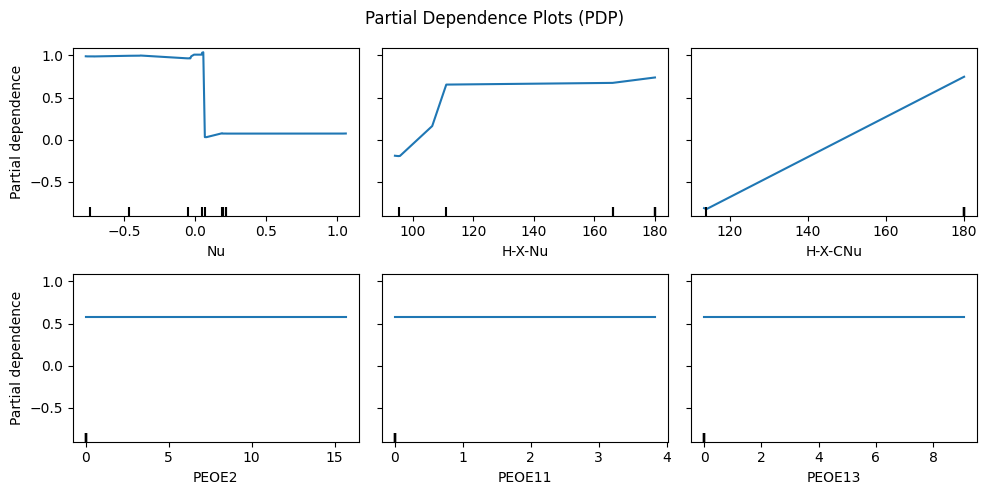

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
pdp_features=[86,96,97,237,244,245 ]
fig, ax = plt.subplots(2,3,figsize=(10,5))
# ax.set_title("Decision Tree")
fig.suptitle('Partial Dependence Plots (PDP)')
PartialDependenceDisplay.from_estimator(svc, X_train, pdp_features,ax=ax)
fig.tight_layout()

Analysis without Nucleophile's features

In [ ]:
X = X_iminium

In [ ]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM')
X_train2 = pd.read_excel('X_train1_nonuc.xlsx', index_col=0)

In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import heapq
import matplotlib.pyplot as plt


from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot


from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr
from numpy.random import random


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:

X_train_train, X_valid, Y_train_train, Y_valid = train_test_split( X_train2,Y_train1, test_size = 0.2, random_state = 100)



X_valid=X_valid.to_numpy()
Y_valid=Y_valid.to_numpy()
X_train_train=X_train_train.to_numpy()
Y_train_train=Y_train_train.to_numpy()

In [ ]:

validation_replication=1
result_valid=np.zeros(validation_replication)
result_valid=np.reshape(result_valid,(1,validation_replication))








def objective(x1):

    # Constraints for each hyperparameter
    # All hyperparameters are positive integers.
    # Minimum of "n_estimators" : 1.

    a1 = int(x1)


    if a1<1:
        a1=1


# Performance evaluation for  validation set
    for j in range(0,1):
        # Fit the model with training data and check the Mean Absolute Percentage Error (MAPE) of validation data
        reg_m = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=a1,random_state=5))
        reg_m.fit(X_train_train, Y_train_train.ravel());

        predicted_y_m = reg_m.predict(X_valid);
        prediction=np.reshape(predicted_y_m,(predicted_y_m.shape[0],1))
        result_valid[0,j] =(mean_squared_error(Y_valid, prediction))
    # Since Bayesian Optimization is maximization problem, we used reciprocal as output.
    return (1/np.mean(result_valid))

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    #with catch_warnings():
        # ignore generated warnings if the distribution is thin at a given point
        #simplefilter("ignore")
        return model.predict(X, return_std=True)

# We used Expected Improvement as our acquisition function.
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    #mu = mu[:, 0]
    # calculate the Expected improvement
    probs = (mu - best) * norm.cdf((mu - best) / (std + 1E-9)) + (std + 1E-9) * norm.pdf((mu - best) / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    np.random.seed(i*100+h*100+100*i1)
    # random search, generate random samples
    X1samples = 100 * random((100,1))

    # calculate the acquisition function for each sample
    Xsamples = X1samples
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix,]



X1 = [100]
X1 = asarray(X1)


y = asarray([objective(X1)])
X = X1
X = X.reshape(len(X1),1)
y = y.reshape(len(y),1)
h=0




# Starting from given 25 points
for i1 in range(0,20):
    np.random.seed(i1*100+i*100)
    X1 = 100* random(1)

    ysample = asarray([objective(X1)])
    Xsample = X1
    Xsample = Xsample.reshape(len(X1),1)
    ysample = ysample.reshape(len(ysample),1)

    X = vstack((X,Xsample))
    y = vstack((y,ysample))
# define the surrogate model
model = GaussianProcessRegressor()
model.fit(X, y)



# Sample new points (hyperparameters) with Bayesian Optimization.
# It sequentialy samples 100 points based on the optimization.
for h in range(100):
    print(h)
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    x = asarray(x)
    # sample the point
    actual = objective(x[0])
    est, _ = surrogate(model,[x])
    actual = asarray(actual)
    #print(' f()=%3f, actual=%.3f' % (est, actual))
    # add the data to the dataset
    X = vstack((X,[x]))
    y = vstack((y,[[actual]]))
    # update the model
    model.fit(X, y)
    # best result
    ix = argmax(y)
    print("Current")
    print(x[0],1/est,1/actual)

#Provide Best hyperparameters settings based on Bayesian Optimization.
print("Best")
print((X[ix, 0],y[ix],1/y[ix]),ix)



a1=int(X[ix,0])

if a1<1:
    a1=1
print(a1)




0
Current
99.21200295448001 [0.48582974] 0.5527806434552713
1
Current
64.34987075099797 [0.52717934] 0.5551218426149622
2
Current
16.617307729478938 [0.49268249] 0.553818481261174
3
Current
44.20324126661561 [0.50470951] 0.5589154269955066
4
Current
54.95037049928564 [0.54931896] 0.5472234627628901
5
Current
68.65454197977625 [0.60170092] 0.5421986716740215
6
Current
65.89240483563081 [0.52289783] 0.5484467118284156
7
Current
32.874382384130854 [0.52931972] 0.5826941668574352
8
Current
13.022130354614402 [0.65713897] 0.5494985605604813
9
Current
58.78933136804887 [0.80190475] 0.5532932429589007
10
Current
59.20970469825686 [0.51951601] 0.5554880477539906
11
Current
2.6011295867361506 [0.65518966] 0.5552727308090194
12
Current
93.9382225858248 [0.77112714] 0.5480969672755273
13
Current
94.41332152681127 [0.51171014] 0.5479777915659747
14
Current
80.93380077919673 [0.68369279] 0.5480060431515965
15
Current
8.811804126067102 [0.7134828] 0.5693201028498912
16
Current
14.270973577646773 [0.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
result_important=np.zeros((264,100))
def run_random_forest(iterations,value):
    scores = pd.DataFrame(columns = ['iteration', 'MSE', 'test r^2', 'train r^2', 'total r^2'])
    #scores.set_index('iteration', inplace = True)
    for i in range(iterations):
        print(i)
        a=10*i
        parameter=a1
        #develop model & scores
        forest = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=parameter,random_state=100))
        # X_train, X_test, Y_train, Y_test = train_test_split(X_train1,  Y_train1, test_size = 0.2, random_state = a)
        X_train, X_test, Y_train, Y_test = train_test_split(X_train2,  Y_train1, test_size = 0.2, random_state = a)

        svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())

        #evaluating performance
        Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

        results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
        results.set_index('Reaction', inplace = True)
        results.columns = ['Actual', 'Predicted']

        Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
        train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
        train_results.set_index('Reaction', inplace = True)
        train_results.columns = ['Actual', 'Predicted']

        all_results = pd.concat([train_results, results])

        scores = scores.append({'iteration': str(i+1),
                    'MSE': mean_squared_error(Y_test, Y_pred),
                    'test r^2': r2_score(Y_test, Y_pred),
                    'train r^2': r2_score(train_results['Actual'], train_results['Predicted']),
                    'total r^2': r2_score(all_results['Actual'], all_results['Predicted'])}, ignore_index = True)

        perm = PermutationImportance(svc).fit(X_train, Y_train, scoring='neg_mean_squared_error')

        if i == 0:
            total_features_mean = (perm.feature_importances_)
        else:
            total_features_mean = total_features_mean+(perm.feature_importances_)
        result_important[:,i]=perm.feature_importances_
        if i == 0:
            total_features_std = perm.feature_importances_std_
        else:
            total_features_std = total_features_std+perm.feature_importances_std_

    return scores, total_features_mean ,  total_features_std

In [ ]:
import warnings
warnings.filterwarnings("ignore")
for i in range(1,2):
  print("Parameter")
  print(0.1*i)
  results_svr, mean, std = run_random_forest(100,i)
  print(results_svr)
  print(results_svr.mean())
  print(results_svr.std())
  # print(mean)
  # print(std)

Parameter
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   iteration       MSE  test r^2  train r^2  total r^2
0          1  0.458059  0.826476   0.944480   0.922874
1          2  0.428054  0.863298   0.941829   0.924831
2          3  0.586625  0.789438   0.940752   0.911716
3          4  0.578185  0.774509   0.948621   0.917478
4          5  0.303453  0.897083   0.928953   0.922403
..       ...       ...       ...        ...        ...
95        96  0.224628  0.931131   0.922003   0.924300
96        97  0.687232  0.798259   0.937363   0.905006
97        98  0.531541  0.812489   0.940562   0.915193
98        99  0.318546  0.888428   0.941118   0.930875
99       100  0.351477  0.846311   0.950866   0.934323

[100 rows x 5 columns]
iteration   